In [1]:
# =========================================
# 1) Cargar datos y objetivo
# =========================================
import os, json, warnings, platform, datetime
import numpy as np
import pandas as pd
import joblib
warnings.filterwarnings("ignore")
TS = "v1"# datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_FILE = "credito_cleandata_4model.csv"     # <-- tu archivo limpio
assert os.path.exists(DATA_FILE), f"No se encuentra {DATA_FILE}"
df = pd.read_csv(DATA_FILE)

target_clf = "Aprobado"
target_reg = "Line credito"
TARGET    = target_clf
df = df.drop(columns=[target_reg], errors="ignore")

label_map = {"No": 0, "Sí": 1}
y  = df[TARGET].map(label_map).astype(int)
X  = df.drop(columns=[TARGET])

print("Shape:", X.shape, "| Prevalencia(POS=1):", (y==1).mean())


Shape: (60, 7) | Prevalencia(POS=1): 0.5


In [13]:
df.head()

,Sexo,Trabajo dependiente,Funcion principal,Nivel estudio,Edad,Antiguedad ultimo trabajo,Ingreso mes,Aprobado
0,Femenino,Sí,Administrativo,Secundaria,25,3,2798,No
1,Femenino,Sí,Producción,Técnico,35,5,4044,No
2,Femenino,Sí,Servicio al cliente,Bachiller,32,2,3210,No
3,Masculino,Sí,Administrativo,Bachiller,44,5,4527,No
4,Masculino,Sí,Servicio al cliente,Magíster,45,6,5018,No


In [14]:
# =========================================
# 2) Split temprano (TRAIN/TEST) estratificado
# =========================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print("Train:", X_train.shape, "| Test:", X_test.shape)
print("Prevalencia TRAIN (POS=1):", round(float((y_train==1).mean()), 6))
print("Prevalencia TEST  (POS=1):", round(float((y_test==1).mean()), 6))


Train: (48, 7) | Test: (12, 7)
Prevalencia TRAIN (POS=1): 0.5
Prevalencia TEST  (POS=1): 0.5


In [4]:
# =========================================
# 3) Preprocesamiento (num + nominal OHE + ordinal OrdinalEncoder) + SMOTE
# =========================================
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Listas EXACTAS (tuyas)
cat_nominal = ["Sexo", "Trabajo dependiente", "Funcion principal"]
cat_ordinal = ["Nivel estudio"]
num_cols    = ["Edad", "Antiguedad ultimo trabajo", "Ingreso mes"]

# Filtramos por si alguna no está en el dataset (no detenemos ejecución)
cat_nominal_ = [c for c in cat_nominal if c in X_train.columns]
cat_ordinal_ = [c for c in cat_ordinal if c in X_train.columns]
num_features = [c for c in num_cols if c in X_train.columns]

# ORDEN para la(s) variable(s) ordinal(es).
# Asegúrate de que coincidan exactamente con los valores presentes en la data.
# Si tu "Nivel estudio" usa otros rótulos, actualízalos aquí.
orden_estudio = [
    ["Primaria", "Secundaria", "Técnico", "Bachiller", "Licenciado", "Maestría", "Doctorado"]
]

# NOTA: OrdinalEncoder requiere una lista de listas en "categories", una por cada columna ordinal.
# Si tuvieras más de una columna ordinal, agrega otra lista con su orden correspondiente.

preprocessor = ColumnTransformer(
    transformers=[
        ("num",     StandardScaler(), num_features),
        ("nominal", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), cat_nominal_),
        ("ordinal", OrdinalEncoder(categories=orden_estudio,
                                   handle_unknown="use_encoded_value",
                                   unknown_value=-1), cat_ordinal_),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

smote = SMOTE(random_state=RANDOM_STATE)

def build_pipe(model):
    return ImbPipeline(steps=[
        ("prep", preprocessor),
        ("smote", smote),
        ("model", model),
    ])

print("Numéricas:", num_features)
print("Nominales (OHE):", cat_nominal_)
print("Ordinales (OrdinalEncoder):", cat_ordinal_)
print("Orden definido para 'Nivel estudio':", orden_estudio[0])


Numéricas: ['Edad', 'Antiguedad ultimo trabajo', 'Ingreso mes']
Nominales (OHE): ['Sexo', 'Trabajo dependiente', 'Funcion principal']
Ordinales (OrdinalEncoder): ['Nivel estudio']
Orden definido para 'Nivel estudio': ['Primaria', 'Secundaria', 'Técnico', 'Bachiller', 'Licenciado', 'Maestría', 'Doctorado']


In [7]:
# =========================================
# 4) Modelos candidatos (tu lista solicitada)
#     - Incluye guardas de disponibilidad para XGB/LGB/CAT
# =========================================
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Gradiente boosting libs (pueden no estar instaladas en algunos entornos)
try:
    from xgboost import XGBClassifier
    _HAS_XGB = True
except Exception as _e:
    XGBClassifier = None
    _HAS_XGB = False
    print("Aviso: xgboost no disponible -> se omitirá 'XGB' en candidates.")

try:
    from lightgbm import LGBMClassifier
    _HAS_LGB = True
except Exception as _e:
    LGBMClassifier = None
    _HAS_LGB = False
    print("Aviso: lightgbm no disponible -> se omitirá 'LGB' en candidates.")

try:
    from catboost import CatBoostClassifier
    _HAS_CAT = True
except Exception as _e:
    CatBoostClassifier = None
    _HAS_CAT = False
    print("Aviso: catboost no disponible -> se omitirá 'CAT' en candidates.")

candidates = [
    ("LRN", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
    # ("LDA", LinearDiscriminantAnalysis()),
    ("KNN", KNeighborsClassifier()),
    ("GNB", GaussianNB()),
    ("DTS", DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ("RFS", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)),
    ("MLP", MLPClassifier(hidden_layer_sizes=(64,), max_iter=600, random_state=RANDOM_STATE)),
]

# Añadir condicionalmente los boosting si están disponibles
if _HAS_XGB:
    candidates.append((
        "XGB",
        XGBClassifier(
            tree_method="hist", eval_metric="logloss", random_state=RANDOM_STATE,
            n_estimators=400, learning_rate=0.05, max_depth=6,
            subsample=0.9, colsample_bytree=0.9, n_jobs=-1
        )
    ))

if _HAS_LGB:
    candidates.append((
        "LGB",
        LGBMClassifier(
            n_estimators=500, learning_rate=0.05, max_depth=-1,
            subsample=0.9, colsample_bytree=0.9,
            random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1
        )
    ))

if _HAS_CAT:
    candidates.append((
        "CAT",
        CatBoostClassifier(
            iterations=600, learning_rate=0.05, depth=6,
            random_state=RANDOM_STATE, l2_leaf_reg=3.0,
            verbose=False, allow_writing_files=False, thread_count=-1
        )
    ))

print("Candidatos:", [n for n,_ in candidates])


Candidatos: ['LRN', 'KNN', 'GNB', 'DTS', 'RFS', 'MLP', 'XGB', 'LGB', 'CAT']


In [8]:
# =========================================
# 5) Baseline con CV (sin tuning) — limpio, con Precision/Recall en decimales
#    Ranking por F1 (macro); PR-AUC y ROC-AUC como desempates
# =========================================
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, matthews_corrcoef, precision_score, recall_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Scorers binarios para POS=1 ("Sí" → 1)
precision_pos1 = make_scorer(precision_score, average="binary", pos_label=1, zero_division=0)
recall_pos1    = make_scorer(recall_score,    average="binary", pos_label=1, zero_division=0)

scoring = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "roc_auc": "roc_auc",
    "average_precision": "average_precision",  # PR-AUC
    "mcc": make_scorer(matthews_corrcoef),
    "precision": precision_pos1,               # Precision (POS=1)
    "recall": recall_pos1,                     # Recall    (POS=1)
}

baseline_rows = []
for name, model in candidates:
    pipe = build_pipe(model)
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

    row = {
        "model":        name,
        "acc_mean":     scores["test_accuracy"].mean(),
        "acc_std":      scores["test_accuracy"].std(),
        "balacc_mean":  scores["test_balanced_accuracy"].mean(),
        "balacc_std":   scores["test_balanced_accuracy"].std(),
        "prec_mean":    scores["test_precision"].mean(),      # decimales (0–1)
        "rec_mean":     scores["test_recall"].mean(),         # decimales (0–1)
        "f1_mean":      scores["test_f1_macro"].mean(),
        "f1_std":       scores["test_f1_macro"].std(),
        "roc_auc_mean": scores["test_roc_auc"].mean(),
        "pr_auc_mean":  scores["test_average_precision"].mean(),
        "mcc_mean":     scores["test_mcc"].mean(),
    }
    baseline_rows.append(row)

    print(f"{name:>4} | ACC {row['acc_mean']:.3f} | BALACC {row['balacc_mean']:.3f} "
          f"| PREC {row['prec_mean']:.3f} | REC {row['rec_mean']:.3f} "
          f"| F1 {row['f1_mean']:.3f} | ROC-AUC {row['roc_auc_mean']:.3f} "
          f"| PR-AUC {row['pr_auc_mean']:.3f} | MCC {row['mcc_mean']:.3f}")

# Ranking por F1 (macro); desempate por PR-AUC, luego ROC-AUC
baseline_df = (
    pd.DataFrame(baseline_rows)
      .sort_values(["f1_mean", "pr_auc_mean", "roc_auc_mean"], ascending=False)
      .reset_index(drop=True)
)

baseline_best_name  = baseline_df.iloc[0]["model"]
baseline_best_model = dict(candidates)[baseline_best_name]
print(f">>> Baseline ganador: {baseline_best_name}")


 LRN | ACC 0.938 | BALACC 0.940 | PREC 0.927 | REC 0.960 | F1 0.937 | ROC-AUC 0.990 | PR-AUC 0.990 | MCC 0.887
 KNN | ACC 0.849 | BALACC 0.850 | PREC 0.833 | REC 0.910 | F1 0.846 | ROC-AUC 0.887 | PR-AUC 0.861 | MCC 0.716
 GNB | ACC 0.733 | BALACC 0.735 | PREC 0.739 | REC 0.790 | F1 0.728 | ROC-AUC 0.846 | PR-AUC 0.894 | MCC 0.471
 DTS | ACC 0.960 | BALACC 0.960 | PREC 1.000 | REC 0.920 | F1 0.958 | ROC-AUC 0.960 | PR-AUC 0.960 | MCC 0.931
 RFS | ACC 0.960 | BALACC 0.960 | PREC 1.000 | REC 0.920 | F1 0.958 | ROC-AUC 1.000 | PR-AUC 1.000 | MCC 0.931
 MLP | ACC 0.851 | BALACC 0.845 | PREC 0.860 | REC 0.820 | F1 0.846 | ROC-AUC 0.926 | PR-AUC 0.939 | MCC 0.705
 XGB | ACC 0.960 | BALACC 0.960 | PREC 1.000 | REC 0.920 | F1 0.958 | ROC-AUC 1.000 | PR-AUC 1.000 | MCC 0.931
 LGB | ACC 0.589 | BALACC 0.585 | PREC 0.267 | REC 0.250 | F1 0.483 | ROC-AUC 0.585 | PR-AUC 0.582 | MCC 0.168
 CAT | ACC 0.960 | BALACC 0.960 | PREC 1.000 | REC 0.920 | F1 0.958 | ROC-AUC 1.000 | PR-AUC 1.000 | MCC 0.931
>

In [9]:
# =========================================
# 5.x) Exportar métricas a CSV — nombres solicitados
#     reports/step5_baseline_metrics_{TS}.csv
#     reports/step5_baseline_metrics_{TS}_meta.csv
# =========================================
import os

# Asegúrate de tener TS definido en el Paso 1:

REPORTS_DIR = "reports"
os.makedirs(REPORTS_DIR, exist_ok=True)

metrics_csv = os.path.join(REPORTS_DIR, f"step5_baseline_metrics_{TS}.csv")
meta_csv    = os.path.join(REPORTS_DIR, f"step5_baseline_metrics_{TS}_meta.csv")

# Métricas agregadas (decimales 0-1)
cols_order = [
    "model",
    "acc_mean","acc_std",
    "balacc_mean","balacc_std",
    "prec_mean","rec_mean",
    "f1_mean","f1_std",
    "roc_auc_mean","pr_auc_mean",
    "mcc_mean",
]
export_df = baseline_df[[c for c in cols_order if c in baseline_df.columns]].copy()
export_df.to_csv(metrics_csv, index=False)

# Meta del experimento en CSV separado
meta_rows = [
    ("DATA_FILE", DATA_FILE),
    ("TARGET", "Aprobado"),
    ("RANDOM_STATE", RANDOM_STATE),
    ("y_train_prevalence(POS=1)", round(float((y_train==1).mean()), 6)),
    ("y_test_prevalence(POS=1)",  round(float((y_test==1).mean()),  6)),
    ("n_train", int(len(y_train))),
    ("n_test",  int(len(y_test))),
    ("cv_n_splits", int(cv.get_n_splits())),
    ("cv_type", type(cv).__name__),
    ("smote", f"enabled (k_neighbors={getattr(smote, 'k_neighbors', None)})"),
    ("ohe_handle_unknown", "ignore"),
    ("scaler", "StandardScaler (num)"),
    ("version_TS", TS),
    ("num_cols", ", ".join(num_cols)),
    ("cat_nominal", ", ".join(cat_nominal)),
    ("cat_ordinal", ", ".join(cat_ordinal)),
]
pd.DataFrame(meta_rows, columns=["key","value"]).to_csv(meta_csv, index=False)

print(f"✔ CSV exportados:\n- {metrics_csv}\n- {meta_csv}")


✔ CSV exportados:
- reports/step5_baseline_metrics_v1.csv
- reports/step5_baseline_metrics_v1_meta.csv


In [10]:
# =========================================
# 6) Tuning con CV y elección del ganador (rápido) + métricas extra
#    - Sin export aquí (va en 6.x)
#    - Ranking por F1 (macro); PR-AUC y ROC-AUC como desempates
# =========================================
import tempfile, shutil, numpy as np, pandas as pd
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform
try:
    from scipy.stats import loguniform
except Exception:
    from sklearn.utils.fixes import loguniform  # fallback

from sklearn.metrics import make_scorer, matthews_corrcoef, precision_score, recall_score

# (Re)comprobación de disponibilidad para boosting (por si este bloque se ejecuta solo)
try:
    from xgboost import XGBClassifier
    _HAS_XGB = True
except Exception:
    XGBClassifier = None
    _HAS_XGB = False

try:
    from lightgbm import LGBMClassifier
    _HAS_LGB = True
except Exception:
    LGBMClassifier = None
    _HAS_LGB = False

try:
    from catboost import CatBoostClassifier
    _HAS_CAT = True
except Exception:
    CatBoostClassifier = None
    _HAS_CAT = False

cv_light = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_heavy = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# --- espacios de hiperparámetros ---
param_spaces = {
    "LRN": {
        "model__C": loguniform(1e-2, 1e1),
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs","liblinear"],
        "model__class_weight": [None, "balanced"],
    },
    "RFS": {
        "model__n_estimators": randint(200, 500),
        "model__max_depth": randint(4, 14),
        "model__min_samples_split": randint(2, 16),
        "model__min_samples_leaf": randint(1, 8),
        "model__max_features": ["sqrt","log2", None],
        "model__bootstrap": [True, False],
    },
    "XGB": {
        "model__n_estimators": randint(250, 600),
        "model__learning_rate": loguniform(5e-3, 2e-1),
        "model__max_depth": randint(3, 9),
        "model__subsample": uniform(0.7, 0.3),
        "model__colsample_bytree": uniform(0.7, 0.3),
        "model__min_child_weight": randint(1, 6),
    },
    "LGB": {
        "model__n_estimators": randint(300, 800),
        "model__learning_rate": loguniform(5e-3, 2e-1),
        "model__num_leaves": randint(16, 128),
        "model__max_depth": randint(-1, 12),
        "model__min_child_samples": randint(10, 50),
        "model__subsample": uniform(0.7, 0.3),
        "model__colsample_bytree": uniform(0.7, 0.3),
        "model__reg_lambda": loguniform(1e-3, 10),
    },
    "CAT": {
        "model__iterations": randint(300, 700),
        "model__learning_rate": loguniform(5e-3, 2e-1),
        "model__depth": randint(4, 10),
        "model__l2_leaf_reg": loguniform(1e-2, 30),
        "model__border_count": randint(32, 255),
    },
}

# --- modelos a tunear (1 hilo interno; el RandomizedSearch usa n_jobs=-1) ---
to_tune = [
    ("LRN", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
    ("RFS", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=1)),
]
if _HAS_XGB:
    to_tune.append(("XGB", XGBClassifier(tree_method="hist", eval_metric="logloss",
                                         random_state=RANDOM_STATE, n_jobs=1)))
if _HAS_LGB:
    to_tune.append(("LGB", LGBMClassifier(random_state=RANDOM_STATE, n_jobs=1, verbosity=-1)))
if _HAS_CAT:
    to_tune.append(("CAT", CatBoostClassifier(random_state=RANDOM_STATE, verbose=False,
                                              allow_writing_files=False, thread_count=1)))

# --- scorers iguales al paso 5 (Precision/Recall binarios para POS=1) ---
precision_pos1 = make_scorer(precision_score, average="binary", pos_label=1, zero_division=0)
recall_pos1    = make_scorer(recall_score,    average="binary", pos_label=1, zero_division=0)
mcc_scorer     = make_scorer(matthews_corrcoef)

refit_metric = "f1_macro"
scoring_opt = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "roc_auc": "roc_auc",
    "average_precision": "average_precision",  # PR-AUC
    "precision": precision_pos1,
    "recall": recall_pos1,
    "mcc": mcc_scorer,
}

best_models, opt_rows = [], []
cache_dir = tempfile.mkdtemp(prefix="skcache_")

try:
    for name, base_model in to_tune:
        pipe = build_pipe(base_model)

        # cache del preprocesamiento para acelerar
        try:
            pipe.set_params(memory=cache_dir)
        except Exception:
            pass

        heavy = name in ["XGB","LGB","CAT"]
        search = RandomizedSearchCV(
            pipe, param_spaces[name],
            n_iter=(15 if heavy else 12),
            cv=(cv_heavy if heavy else cv_light),
            scoring=scoring_opt,
            refit=refit_metric,
            n_jobs=-1,
            random_state=RANDOM_STATE,
            verbose=1,
            return_train_score=False,
            error_score=np.nan
        )
        search.fit(X_train, y_train)

        # Mejor punto y métricas asociadas (medias y std por CV)
        best_idx = search.best_index_
        cvres    = search.cv_results_

        row = {
            "model":      name,
            "acc_mean":   float(cvres["mean_test_accuracy"][best_idx]),
            "acc_std":    float(cvres["std_test_accuracy"][best_idx]),
            "balacc_mean":float(cvres["mean_test_balanced_accuracy"][best_idx]),
            "balacc_std": float(cvres["std_test_balanced_accuracy"][best_idx]),
            "prec_mean":  float(cvres["mean_test_precision"][best_idx]),
            "prec_std":   float(cvres["std_test_precision"][best_idx]),
            "rec_mean":   float(cvres["mean_test_recall"][best_idx]),
            "rec_std":    float(cvres["std_test_recall"][best_idx]),
            "f1_mean":    float(cvres["mean_test_f1_macro"][best_idx]),
            "f1_std":     float(cvres["std_test_f1_macro"][best_idx]),
            "roc_auc_mean": float(cvres["mean_test_roc_auc"][best_idx]),
            "roc_auc_std":  float(cvres["std_test_roc_auc"][best_idx]),
            "pr_auc_mean":  float(cvres["mean_test_average_precision"][best_idx]),
            "pr_auc_std":   float(cvres["std_test_average_precision"][best_idx]),
            "mcc_mean":     float(cvres["mean_test_mcc"][best_idx]),
            "mcc_std":      float(cvres["std_test_mcc"][best_idx]),
            "best_params_len": int(len(search.best_params_)),
        }
        opt_rows.append(row)

        best_models.append((name, search.best_estimator_, search.best_score_, search.best_params_))

        # print resumen una línea por modelo
        print(f"{name:>4} | ACC {row['acc_mean']:.3f} | BALACC {row['balacc_mean']:.3f} "
              f"| PREC {row['prec_mean']:.3f} | REC {row['rec_mean']:.3f} "
              f"| F1 {row['f1_mean']:.3f} | ROC-AUC {row['roc_auc_mean']:.3f} "
              f"| PR-AUC {row['pr_auc_mean']:.3f} | MCC {row['mcc_mean']:.3f}")

    # Tabla resumen ordenada (F1 macro primero; desempate por PR-AUC y ROC-AUC)
    tuning_df = (
        pd.DataFrame(opt_rows)
          .sort_values(["f1_mean","pr_auc_mean","roc_auc_mean"], ascending=False)
          .reset_index(drop=True)
    )
    display(tuning_df)

    # Elegir ganador por el score de refit (F1 macro CV)
    best_models.sort(key=lambda x: (x[2] if pd.notna(x[2]) else -1), reverse=True)
    best_name, final_pipe_opt, best_cv_f1, best_params = best_models[0]
    print(f">>> GANADOR OPTIMIZADO: {best_name} (F1 CV={best_cv_f1:.4f})")

finally:
    shutil.rmtree(cache_dir, ignore_errors=True)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
 LRN | ACC 0.958 | BALACC 0.960 | PREC 0.960 | REC 0.960 | F1 0.958 | ROC-AUC 1.000 | PR-AUC 1.000 | MCC 0.923
Fitting 5 folds for each of 12 candidates, totalling 60 fits
 RFS | ACC 0.960 | BALACC 0.960 | PREC 1.000 | REC 0.920 | F1 0.958 | ROC-AUC 1.000 | PR-AUC 1.000 | MCC 0.931
Fitting 3 folds for each of 15 candidates, totalling 45 fits
 XGB | ACC 0.958 | BALACC 0.958 | PREC 1.000 | REC 0.917 | F1 0.958 | ROC-AUC 0.948 | PR-AUC 0.967 | MCC 0.925
Fitting 3 folds for each of 15 candidates, totalling 45 fits
 LGB | ACC 0.958 | BALACC 0.958 | PREC 1.000 | REC 0.917 | F1 0.958 | ROC-AUC 0.927 | PR-AUC 0.958 | MCC 0.925
Fitting 3 folds for each of 15 candidates, totalling 45 fits
 CAT | ACC 0.958 | BALACC 0.958 | PREC 1.000 | REC 0.917 | F1 0.958 | ROC-AUC 0.990 | PR-AUC 0.990 | MCC 0.925


,model,acc_mean,acc_std,balacc_mean,balacc_std,prec_mean,prec_std,rec_mean,rec_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,mcc_mean,mcc_std,best_params_len
0,RFS,0.960000,0.080000,0.960000,0.080000,1.00,0.00,0.920000,0.160000,0.958333,0.083333,1.000000,0.000000,1.000000,0.000000,0.930931,0.138139,6
1,CAT,0.958333,0.058926,0.958333,0.058926,1.00,0.00,0.916667,0.117851,0.957672,0.059861,0.989583,0.014731,0.990162,0.013913,0.924866,0.106256,5
2,XGB,0.958333,0.058926,0.958333,0.058926,1.00,0.00,0.916667,0.117851,0.957672,0.059861,0.947917,0.073657,0.966667,0.047140,0.924866,0.106256,6
3,LGB,0.958333,0.058926,0.958333,0.058926,1.00,0.00,0.916667,0.117851,0.957672,0.059861,0.927083,0.103120,0.958333,0.058926,0.924866,0.106256,8
4,LRN,0.957778,0.051831,0.960000,0.048990,0.96,0.08,0.960000,0.080000,0.957576,0.052057,1.000000,0.000000,1.000000,0.000000,0.923299,0.094084,4


>>> GANADOR OPTIMIZADO: RFS (F1 CV=0.9583)


In [11]:
# =========================================
# 6.x) Exportar métricas de tuning a CSV (solo CSV; meta aparte)
#     Requiere: tuning_df, best_name, best_cv_f1, best_params
# =========================================
import os, json

REPORTS_DIR = "reports"
os.makedirs(REPORTS_DIR, exist_ok=True)

metrics_csv = os.path.join(REPORTS_DIR, f"step6_tuning_metrics_{TS}.csv")
meta_csv    = os.path.join(REPORTS_DIR, f"step6_tuning_metrics_{TS}_meta.csv")

# Métricas (orden sugerido de columnas si existen)
cols_order = [
    "model",
    "acc_mean","acc_std",
    "balacc_mean","balacc_std",
    "prec_mean","prec_std",
    "rec_mean","rec_std",
    "f1_mean","f1_std",
    "roc_auc_mean","roc_auc_std",
    "pr_auc_mean","pr_auc_std",
    "mcc_mean","mcc_std",
    "best_params_len",
]
export_df = tuning_df[[c for c in cols_order if c in tuning_df.columns]].copy()
export_df.to_csv(metrics_csv, index=False)

# Meta del tuning (incluye el ganador y sus parámetros)
meta_rows = [
    ("DATA_FILE", DATA_FILE),
    ("TARGET", TARGET),
    ("RANDOM_STATE", RANDOM_STATE),
    ("refit_metric", "f1_macro"),
    ("cv_light_splits", getattr(cv_light, "n_splits", None)),
    ("cv_heavy_splits", getattr(cv_heavy, "n_splits", None)),
    ("heavy_models", "XGB,LGB,CAT"),
    ("n_iter_light", 12),
    ("n_iter_heavy", 15),
    ("winner_best_name", best_name),
    ("winner_best_cv_f1", round(float(best_cv_f1), 6)),
    ("winner_best_params", json.dumps(best_params, ensure_ascii=False)),
    ("version_TS", TS),
]
pd.DataFrame(meta_rows, columns=["key","value"]).to_csv(meta_csv, index=False)

print(f"✔ CSV exportados:\n- {metrics_csv}\n- {meta_csv}")


✔ CSV exportados:
- reports/step6_tuning_metrics_v1.csv
- reports/step6_tuning_metrics_v1_meta.csv


In [12]:
# =========================================
# 7) Comparación justa (solo CV) - baseline vs ganador
#    - Mismas métricas (decimales) y mismo CV para ambos
#    - NO exporta aquí (eso va en 7.x)
# =========================================
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, matthews_corrcoef
import pandas as pd

same_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Scorers binarios para POS=1 (decimales)
precision_pos1 = make_scorer(precision_score, average="binary", pos_label=1, zero_division=0)
recall_pos1    = make_scorer(recall_score,    average="binary", pos_label=1, zero_division=0)
mcc_scorer     = make_scorer(matthews_corrcoef)

scoring7 = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "roc_auc": "roc_auc",
    "average_precision": "average_precision",  # PR-AUC
    "f1_macro": "f1_macro",
    "precision": precision_pos1,
    "recall": recall_pos1,
    "mcc": mcc_scorer,
}

pipe_baseline_best = build_pipe(baseline_best_model)
pipe_tuned_best    = final_pipe_opt

def cv_summary(pipe, tag):
    s = cross_validate(pipe, X_train, y_train, cv=same_cv, scoring=scoring7, n_jobs=-1)
    row = {
        "acc_mean":      s["test_accuracy"].mean(),
        "balacc_mean":   s["test_balanced_accuracy"].mean(),
        "prec_mean":     s["test_precision"].mean(),
        "rec_mean":      s["test_recall"].mean(),
        "f1_mean":       s["test_f1_macro"].mean(),
        "roc_auc_mean":  s["test_roc_auc"].mean(),
        "pr_auc_mean":   s["test_average_precision"].mean(),
        "mcc_mean":      s["test_mcc"].mean(),
    }
    print(f"{tag:>12} | ACC {row['acc_mean']:.3f} | BALACC {row['balacc_mean']:.3f} "
          f"| PREC {row['prec_mean']:.3f} | REC {row['rec_mean']:.3f} | F1 {row['f1_mean']:.3f} "
          f"| ROC-AUC {row['roc_auc_mean']:.3f} | PR-AUC {row['pr_auc_mean']:.3f} | MCC {row['mcc_mean']:.3f}")
    return row

row_base = cv_summary(pipe_baseline_best, f"Baseline({baseline_best_name})")
row_tune = cv_summary(pipe_tuned_best,   f"Tuned({best_name})")

delta = row_tune["f1_mean"] - row_base["f1_mean"]
print(f"ΔF1 (Tuned - Baseline): {delta:.4f}")

# Regla: si la mejora < 0.005, elegir el más simple (baseline); si no, el tuned.
if delta >= 0.005:
    winner_name, winner_pipe = best_name, pipe_tuned_best
else:
    winner_name, winner_pipe = baseline_best_name, pipe_baseline_best

print(f">>> Modelo seleccionado para TEST: {winner_name}")

# Dejar lista una tabla para exportar en 7.x
compare_df = pd.DataFrame([
    {"model": f"Baseline({baseline_best_name})", **row_base},
    {"model": f"Tuned({best_name})",            **row_tune},
])


Baseline(RFS) | ACC 0.958 | BALACC 0.955 | PREC 1.000 | REC 0.910 | F1 0.956 | ROC-AUC 1.000 | PR-AUC 1.000 | MCC 0.921
  Tuned(RFS) | ACC 0.980 | BALACC 0.980 | PREC 1.000 | REC 0.960 | F1 0.980 | ROC-AUC 1.000 | PR-AUC 1.000 | MCC 0.963
ΔF1 (Tuned - Baseline): 0.0234
>>> Modelo seleccionado para TEST: RFS


In [21]:
# =========================================
# 7.x) Exportar comparación justa a CSV (solo CSV; meta aparte)
#     Requiere: compare_df, delta, winner_name
# =========================================
import os
import pandas as pd

REPORTS_DIR = "reports"
os.makedirs(REPORTS_DIR, exist_ok=True)

metrics_csv = os.path.join(REPORTS_DIR, f"step7_fair_compare_{TS}.csv")
meta_csv    = os.path.join(REPORTS_DIR, f"step7_fair_compare_{TS}_meta.csv")

# Métricas lado a lado (Baseline vs Tuned)
compare_df.to_csv(metrics_csv, index=False)

# Meta con decisión y parámetros clave
meta_rows = [
    ("baseline_best_name", baseline_best_name),
    ("tuned_best_name",    best_name),
    ("delta_f1_macro",     round(float(delta), 6)),
    ("winner_name",        winner_name),
    ("cv_same_splits",     getattr(same_cv, "n_splits", None)),
    ("cv_type",            type(same_cv).__name__),
    ("version_TS",         TS),
]
pd.DataFrame(meta_rows, columns=["key","value"]).to_csv(meta_csv, index=False)

print(f"✔ CSV exportados:\n- {metrics_csv}\n- {meta_csv}")


✔ CSV exportados:
- reports/step7_fair_compare_v1.csv
- reports/step7_fair_compare_v1_meta.csv


In [22]:
# =========================================
# 8) Política de decisión (umbral en TRAIN, OOF-CV)
#    - Usa cross_val_predict para obtener proba OOF en TRAIN
#    - Selecciona BEST_THR maximizando F1_macro (desempate: BALACC, PREC, REC)
#    - NO exporta aquí (8.x hará el CSV)
# =========================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, roc_auc_score, average_precision_score
)

# 1) Probabilidades OOF (solo sobre TRAIN, sin tocar TEST)
cv_thr = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof_proba = cross_val_predict(
    winner_pipe, X_train, y_train,
    cv=cv_thr, method="predict_proba", n_jobs=-1
)[:, 1]

# 2) Barrido de umbrales y métricas (decimales)
thresholds = np.linspace(0.05, 0.95, 91)  # de 0.05 a 0.95 cada 0.01
rows = []
for thr in thresholds:
    y_hat = (oof_proba >= thr).astype(int)
    rows.append({
        "thr": float(thr),
        "acc": accuracy_score(y_train, y_hat),
        "balacc": balanced_accuracy_score(y_train, y_hat),
        "prec": precision_score(y_train, y_hat, pos_label=1, zero_division=0),
        "rec":  recall_score(y_train, y_hat,  pos_label=1, zero_division=0),
        "f1_macro": f1_score(y_train, y_hat, average="macro"),
        "f1_pos1":  f1_score(y_train, y_hat, pos_label=1),
        "mcc": matthews_corrcoef(y_train, y_hat),
    })
thr_df = pd.DataFrame(rows)

# 3) Selección según criterio principal (F1_macro); desempates: BALACC, PREC, REC
thr_df = thr_df.sort_values(
    ["f1_macro", "balacc", "prec", "rec", "mcc"],
    ascending=False
).reset_index(drop=True)

BEST_THR = float(thr_df.iloc[0]["thr"])

# 4) Métricas OOF al BEST_THR + AUC threshold-free (de referencia)
y_hat_best = (oof_proba >= BEST_THR).astype(int)
oof_metrics = {
    "ACC":    accuracy_score(y_train, y_hat_best),
    "BALACC": balanced_accuracy_score(y_train, y_hat_best),
    "PREC":   precision_score(y_train, y_hat_best, pos_label=1, zero_division=0),
    "REC":    recall_score(y_train, y_hat_best,    pos_label=1, zero_division=0),
    "F1":     f1_score(y_train, y_hat_best,        pos_label=1),
    "F1_MAC": f1_score(y_train, y_hat_best, average="macro"),
    "MCC":    matthews_corrcoef(y_train, y_hat_best),
    "ROC_AUC_OOF": roc_auc_score(y_train, oof_proba),
    "PR_AUC_OOF":  average_precision_score(y_train, oof_proba),
}

print(f">>> Umbral seleccionado (OOF CV, criterio=F1_macro): {BEST_THR:.3f}")
print(f"ACC {oof_metrics['ACC']:.3f} | BALACC {oof_metrics['BALACC']:.3f} "
      f"| PREC {oof_metrics['PREC']:.3f} | REC {oof_metrics['REC']:.3f} "
      f"| F1 {oof_metrics['F1']:.3f} | F1_MAC {oof_metrics['F1_MAC']:.3f} "
      f"| MCC {oof_metrics['MCC']:.3f} | ROC-AUC(OOF) {oof_metrics['ROC_AUC_OOF']:.3f} "
      f"| PR-AUC(OOF) {oof_metrics['PR_AUC_OOF']:.3f}")

# Deja listo un DataFrame 'thr_df' ordenado para exportar en 8.x (CSV)
# columnas: ['thr','acc','balacc','prec','rec','f1_macro','f1_pos1','mcc']


>>> Umbral seleccionado (OOF CV, criterio=F1_macro): 0.480
ACC 0.958 | BALACC 0.958 | PREC 1.000 | REC 0.917 | F1 0.957 | F1_MAC 0.958 | MCC 0.920 | ROC-AUC(OOF) 0.970 | PR-AUC(OOF) 0.978


In [23]:
# =========================================
# 8.x) Exportar política de decisión y barrido de umbrales (OOF)
#     Requiere: thr_df, BEST_THR, oof_proba, y_train
# =========================================
import os, json
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, roc_auc_score, average_precision_score
)

# Guardas mínimas
req_vars = ["thr_df", "BEST_THR", "oof_proba", "y_train", "winner_name"]
missing = [v for v in req_vars if v not in globals()]
if missing:
    raise RuntimeError(f"Faltan variables para exportar 8.x: {missing}. Ejecuta el Paso 8 primero.")

REPORTS_DIR = "reports"
os.makedirs(REPORTS_DIR, exist_ok=True)

# CSV con todo el barrido
thr_csv  = os.path.join(REPORTS_DIR, f"step8_threshold_sweep_{TS}.csv")
thr_df.to_csv(thr_csv, index=False)

# Resumen OOF en el BEST_THR (recalculo en caso de ejecución aislada)
y_hat_best = (np.asarray(oof_proba) >= float(BEST_THR)).astype(int)
oof_summary = {
    "ACC":    float(accuracy_score(y_train, y_hat_best)),
    "BALACC": float(balanced_accuracy_score(y_train, y_hat_best)),
    "PREC":   float(precision_score(y_train, y_hat_best, pos_label=1, zero_division=0)),
    "REC":    float(recall_score(y_train, y_hat_best,    pos_label=1, zero_division=0)),
    "F1":     float(f1_score(y_train, y_hat_best,        pos_label=1, zero_division=0)),
    "F1_MAC": float(f1_score(y_train, y_hat_best, average="macro")),
    "MCC":    float(matthews_corrcoef(y_train, y_hat_best)),
    "ROC_AUC_OOF": float(roc_auc_score(y_train, oof_proba)),
    "PR_AUC_OOF":  float(average_precision_score(y_train, oof_proba)),
}

# JSON de política de decisión (para servir luego en app)
policy = {
    "model_selected": winner_name,       # del Paso 7
    "best_threshold": float(BEST_THR),   # umbral óptimo OOF
    "oof_summary": oof_summary,          # métricas OOF al BEST_THR
    "notes": "Umbral elegido maximizando F1_macro; desempate por BALACC, PREC, REC, MCC.",
    "version_TS": TS
}

pol_json = os.path.join(REPORTS_DIR, f"step8_decision_policy_{TS}.json")
with open(pol_json, "w", encoding="utf-8") as f:
    json.dump(policy, f, indent=2, ensure_ascii=False)

# Meta (clave-valor simple)
meta_rows = [
    ("DATA_FILE", DATA_FILE),
    ("TARGET", TARGET),
    ("winner_name", winner_name),
    ("BEST_THR", float(BEST_THR)),
    ("y_train_prevalence(POS=1)", float((y_train==1).mean())),
    ("cv_thr_splits", 5),
    ("criterion", "F1_macro; tie-break: balacc, prec, rec, mcc"),
    ("version_TS", TS),
]
meta_csv = os.path.join(REPORTS_DIR, f"step8_threshold_sweep_{TS}_meta.csv")
pd.DataFrame(meta_rows, columns=["key","value"]).to_csv(meta_csv, index=False)

print("✔ Export 8.x listo:")
print("-", thr_csv)
print("-", pol_json)
print("-", meta_csv)


✔ Export 8.x listo:
- reports/step8_threshold_sweep_v1.csv
- reports/step8_decision_policy_v1.json
- reports/step8_threshold_sweep_v1_meta.csv


In [24]:
# =========================================
# 9) Evaluación final en TEST
# =========================================
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score, matthews_corrcoef,
    balanced_accuracy_score, accuracy_score
)

print(f"\n== Evaluación en TEST (umbral={BEST_THR:.2f}) ==")

winner_pipe.fit(X_train, y_train)
proba_test = winner_pipe.predict_proba(X_test)[:, 1]
y_pred     = (proba_test >= BEST_THR).astype(int)

# Métricas resumen (decimales)
acc    = accuracy_score(y_test, y_pred)
balacc = balanced_accuracy_score(y_test, y_pred)
prec1  = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
rec1   = recall_score(y_test, y_pred,    pos_label=1, zero_division=0)
f1     = f1_score(y_test, y_pred,        pos_label=1, zero_division=0)
mcc    = matthews_corrcoef(y_test, y_pred)
roc    = roc_auc_score(y_test, proba_test)
pr     = average_precision_score(y_test, proba_test)

print(f"TEST | ACC {acc:.3f} | BALACC {balacc:.3f} | PREC {prec1:.3f} | REC {rec1:.3f} | "
      f"F1 {f1:.3f} | ROC-AUC {roc:.3f} | PR-AUC {pr:.3f} | MCC {mcc:.3f}")

# Reporte por clase label_map = {"No": 0, "Sí": 1}

print("\nReporte de Clasificación (por clase):")
print(classification_report(y_test, y_pred, target_names=[f"{k.upper()}({v})" for k, v in label_map.items()], digits=4))

# Matriz de confusión etiquetada (impresa)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cm_df = pd.DataFrame(cm, 
                     index=[f"Real {v}-{k.upper()}" for k, v in label_map.items()], 
                     columns=[f"Pred {v}-{k.upper()}" for k, v in label_map.items()]
)
print("\nMatriz de confusión:")
print(cm_df.to_string())

# Extras útiles
print("\nExtras:")
print(f"Prevalencia real en TEST (POS=1): {(y_test==1).mean():.4f}")
print(f"Predichos positivos (NEG=1): {int((y_pred==1).sum())} de {len(y_pred)} ({(y_pred==1).mean():.4f})")



== Evaluación en TEST (umbral=0.48) ==
TEST | ACC 1.000 | BALACC 1.000 | PREC 1.000 | REC 1.000 | F1 1.000 | ROC-AUC 1.000 | PR-AUC 1.000 | MCC 1.000

Reporte de Clasificación (por clase):
              precision    recall  f1-score   support

       NO(0)     1.0000    1.0000    1.0000         6
       SÍ(1)     1.0000    1.0000    1.0000         6

    accuracy                         1.0000        12
   macro avg     1.0000    1.0000    1.0000        12
weighted avg     1.0000    1.0000    1.0000        12


Matriz de confusión:
           Pred 0-NO  Pred 1-SÍ
Real 0-NO          6          0
Real 1-SÍ          0          6

Extras:
Prevalencia real en TEST (POS=1): 0.5000
Predichos positivos (NEG=1): 6 de 12 (0.5000)


In [26]:
# =========================================
# 9.x) Exportar resultados de TEST a CSV (robusto, sin supuestos de orden)
#    - Si y_pred/proba_test no existen, los calcula con winner_pipe y BEST_THR
# =========================================
import os
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score, average_precision_score
)

REPORTS_DIR = "reports"
os.makedirs(REPORTS_DIR, exist_ok=True)

# --- Asegurar predicciones de TEST ---
# Requisitos mínimos para poder calcular todo:
req_vars = ["winner_pipe", "X_train", "y_train", "X_test", "y_test", "BEST_THR"]
missing = [v for v in req_vars if v not in globals()]
if missing:
    raise RuntimeError(f"Faltan variables para exportar TEST: {missing}. Ejecuta pasos 1–8 primero.")

# Si no existen proba_test / y_pred, calcúlalos (entrena si es necesario)
if 'proba_test' not in globals() or 'y_pred' not in globals():
    # Entrena el pipeline ganador si aún no está ajustado
    if not hasattr(winner_pipe, "classes_"):
        winner_pipe.fit(X_train, y_train)
    proba_test = winner_pipe.predict_proba(X_test)[:, 1]
    y_pred     = (proba_test >= float(BEST_THR)).astype(int)

# --- Métricas resumen (decimales) ---
acc    = accuracy_score(y_test, y_pred)
balacc = balanced_accuracy_score(y_test, y_pred)
prec1  = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
rec1   = recall_score(y_test, y_pred,    pos_label=1, zero_division=0)
f1     = f1_score(y_test, y_pred,        pos_label=1, zero_division=0)
mcc    = matthews_corrcoef(y_test, y_pred)
roc    = roc_auc_score(y_test, proba_test)
pr     = average_precision_score(y_test, proba_test)

# --- Rutas de salida ---
metrics_csv = os.path.join(REPORTS_DIR, f"step9_test_metrics_{TS}.csv")
meta_csv    = os.path.join(REPORTS_DIR, f"step9_test_metrics_{TS}_meta.csv")
cm_csv      = os.path.join(REPORTS_DIR, f"step9_confusion_matrix_{TS}.csv")
clsr_csv    = os.path.join(REPORTS_DIR, f"step9_classification_report_{TS}.csv")

# 1) Métricas resumen
pd.DataFrame([{
    "ACC": acc, "BALACC": balacc, "PREC": prec1, "REC": rec1,
    "F1": f1, "ROC_AUC": roc, "PR_AUC": pr, "MCC": mcc
}]).to_csv(metrics_csv, index=False)

# 2) Meta del experimento en TEST
pd.DataFrame([
    ("BEST_THR", float(BEST_THR)),
    ("n_test", int(len(y_test))),
    ("prevalence_test_POS", float((y_test == 1).mean())),
    ("predicted_pos_rate",   float((y_pred == 1).mean())),
    ("DATA_FILE", DATA_FILE),
    ("TARGET", TARGET),
    ("version_TS", TS),
], columns=["key","value"]).to_csv(meta_csv, index=False)

# 3) Matriz de confusión etiquetada
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
pd.DataFrame(cm,
    index=[f"Real {v}-{k.upper()}" for k, v in label_map.items()], 
    columns=[f"Pred {v}-{k.upper()}" for k, v in label_map.items()]
).to_csv(cm_csv)

# 4) Classification report por clase
clsr = classification_report(
    y_test, y_pred,
    target_names=[f"{k.upper()}({v})" for k, v in label_map.items()],
    output_dict=True, digits=6
)
pd.DataFrame(clsr).T.reset_index().rename(columns={"index":"label"}).to_csv(clsr_csv, index=False)

print(f"✔ CSV exportados:\n- {metrics_csv}\n- {meta_csv}\n- {cm_csv}\n- {clsr_csv}")


✔ CSV exportados:
- reports/step9_test_metrics_v1.csv
- reports/step9_test_metrics_v1_meta.csv
- reports/step9_confusion_matrix_v1.csv
- reports/step9_classification_report_v1.csv


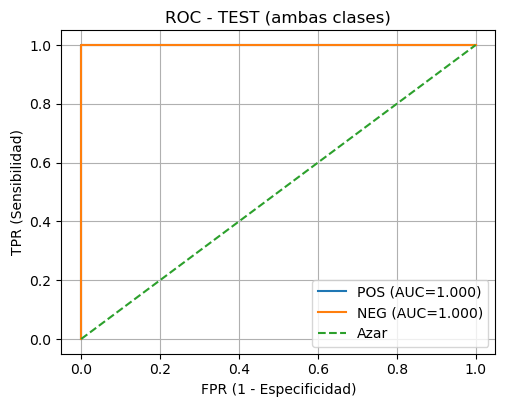

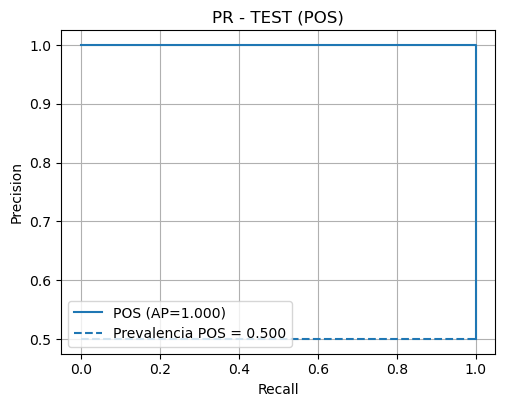

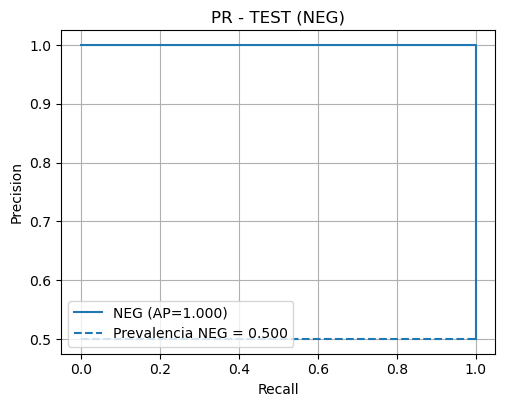

✔ PNG exportados:
- reports/step9_roc_both_v1.png
- reports/step9_pr_POS_v1.png
- reports/step9_pr_NEG_v1.png


In [27]:
# =========================================
# 9.y) Curvas ROC y PR (usa Paso 9) + export PNG
#    - NO reentrena ni vuelve a predecir
# =========================================
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

assert 'proba_test' in globals() and 'y_test' in globals(), "Ejecuta primero el Paso 9."

REPORTS_DIR = "reports"
os.makedirs(REPORTS_DIR, exist_ok=True)

# Probabilidades/clases ya calculadas en Paso 9
proba1 = np.asarray(proba_test)      # P(POS=1)
proba0 = 1.0 - proba1               # P(NEG=0)
y_true  = np.asarray(y_test)
y_true0 = 1 - y_true

# -------- ROC (ambas clases en una figura) --------
fpr1, tpr1, _ = roc_curve(y_true,  proba1)  # POS
roc_auc1 = auc(fpr1, tpr1)

fpr0, tpr0, _ = roc_curve(y_true0, proba0)  # NEG (como positiva)
roc_auc0 = auc(fpr0, tpr0)

plt.figure(figsize=(5.6, 4.2))
plt.plot(fpr1, tpr1, label=f"POS (AUC={roc_auc1:.3f})")
plt.plot(fpr0, tpr0, label=f"NEG (AUC={roc_auc0:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Azar")
plt.xlabel("FPR (1 - Especificidad)")
plt.ylabel("TPR (Sensibilidad)")
plt.title("ROC - TEST (ambas clases)")
plt.legend()
plt.grid(True)
roc_png = os.path.join(REPORTS_DIR, f"step9_roc_both_{TS}.png")
plt.savefig(roc_png, dpi=200, bbox_inches="tight")
plt.show()
plt.close()

# -------- PR (POS) --------
prec1, rec1, _ = precision_recall_curve(y_true,  proba1)
ap1   = average_precision_score(y_true,  proba1)
prev1 = y_true.mean()

plt.figure(figsize=(5.6, 4.2))
plt.step(rec1, prec1, where="post", label=f"POS (AP={ap1:.3f})")
plt.hlines(prev1, 0, 1, linestyles="--", label=f"Prevalencia POS = {prev1:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR - TEST (POS)")
plt.legend()
plt.grid(True)
pr_positivo_png = os.path.join(REPORTS_DIR, f"step9_pr_POS_{TS}.png")
plt.savefig(pr_positivo_png, dpi=200, bbox_inches="tight")
plt.show()
plt.close()

# -------- PR (NEG como positivo) --------
prec0, rec0, _ = precision_recall_curve(y_true0, proba0)
ap0   = average_precision_score(y_true0, proba0)
prev0 = y_true0.mean()

plt.figure(figsize=(5.6, 4.2))
plt.step(rec0, prec0, where="post", label=f"NEG (AP={ap0:.3f})")
plt.hlines(prev0, 0, 1, linestyles="--", label=f"Prevalencia NEG = {prev0:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR - TEST (NEG)")
plt.legend()
plt.grid(True)
pr_negativo_png = os.path.join(REPORTS_DIR, f"step9_pr_NEG_{TS}.png")
plt.savefig(pr_negativo_png, dpi=200, bbox_inches="tight")
plt.show()
plt.close()

print("✔ PNG exportados:")
print("-", roc_png)
print("-", pr_positivo_png)
print("-", pr_negativo_png)


In [28]:
# 9.y.x) Exportar puntos de curvas a CSV (opcional)
import os, pandas as pd
REPORTS_DIR = "reports"; os.makedirs(REPORTS_DIR, exist_ok=True)

pd.DataFrame({"fpr": fpr1, "tpr": tpr1}).to_csv(os.path.join(REPORTS_DIR, f"step9_roc_POS_{TS}.csv"), index=False)
pd.DataFrame({"fpr": fpr0, "tpr": tpr0}).to_csv(os.path.join(REPORTS_DIR, f"step9_roc_NEG_{TS}.csv"), index=False)
pd.DataFrame({"recall": rec1, "precision": prec1}).to_csv(os.path.join(REPORTS_DIR, f"step9_pr_POS_{TS}.csv"), index=False)
pd.DataFrame({"recall": rec0, "precision": prec0}).to_csv(os.path.join(REPORTS_DIR, f"step9_pr_NEG_{TS}.csv"), index=False)
print("✔ CSV de curvas exportados en reports/")


✔ CSV de curvas exportados en reports/


In [29]:
# =========================================
# 10) Interpretabilidad + Error Analysis + Fairness (sin export)
#    Compatible con preprocesador: ("num", ...), ("nominal", OHE), ("ordinal", OrdinalEncoder)
# =========================================
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, classification_report
)

# ---- checks mínimos
assert all(k in globals() for k in [
    "winner_pipe","X_test","y_test","y_pred","proba_test",
    "RANDOM_STATE","TS"
]), "Faltan variables base: ejecuta Paso 9 antes del 10."

prep  = winner_pipe.named_steps["prep"]
model = winner_pipe.named_steps["model"]
X_test_trans = prep.transform(X_test)

# ---- nombres de features post-preprocesamiento (robusto a versión de sklearn)
def _safe_feature_names(prep, X_cols):
    # 1) Intentar API moderna
    try:
        names = prep.get_feature_names_out()
        return names.tolist()
    except Exception:
        pass

    # 2) Reconstruir manualmente: num + nominal(OHE) + ordinal(OrdinalEncoder)
    names = []
    if "num" in prep.named_transformers_:
        # num: los nombres originales que realmente pasaron (intersección con X_test)
        try:
            # si StandardScaler tiene feature_names_in_
            num_pass = prep.named_transformers_["num"].feature_names_in_.tolist()
        except Exception:
            num_pass = [c for c in X_cols if c in getattr(prep.transformers_[0][2], "__iter__", lambda: [])()]
        names += num_pass

    # nominal -> OHE
    if "nominal" in prep.named_transformers_:
        ohe = prep.named_transformers_["nominal"]
        try:
            cat_cols = ohe.feature_names_in_.tolist()
        except Exception:
            # fallback: buscar en prep.transformers_ la entrada 'nominal'
            cat_cols = []
            for name, trans, cols in prep.transformers_:
                if name == "nominal":
                    cat_cols = list(cols)
                    break
        try:
            ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
        except Exception:
            ohe_names = ohe.get_feature_names(cat_cols).tolist()  # muy antiguo
        names += ohe_names

    # ordinal -> OrdinalEncoder (un nombre por columna)
    if "ordinal" in prep.named_transformers_:
        ord_enc = prep.named_transformers_["ordinal"]
        try:
            ord_cols = ord_enc.feature_names_in_.tolist()
        except Exception:
            ord_cols = []
            for name, trans, cols in prep.transformers_:
                if name == "ordinal":
                    ord_cols = list(cols)
                    break
        names += ord_cols

    return names

feat_names = _safe_feature_names(prep, X_test.columns)

# ---- Importancias (CatBoost nativo si aplica; sino Permutation)
imp_source, imp_values = "permutation", None
is_cat = False
try:
    from catboost import Pool, CatBoostClassifier
    is_cat = isinstance(model, CatBoostClassifier)
except Exception:
    is_cat = False

if is_cat:
    # El modelo ha sido entrenado sobre X transformado (numérico), así que usamos ese espacio
    pool_test = Pool(X_test_trans)
    try:
        imp_values = model.get_feature_importance(data=pool_test, type="PredictionValuesChange")
        imp_source = "catboost_prediction_values_change"
    except TypeError:
        imp_values = model.get_feature_importance(pool_test)
        imp_source = "catboost_feature_importance"
else:
    pi = permutation_importance(
        model, X_test_trans, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
    )
    imp_values = pi.importances_mean
    imp_source = "permutation_importance"

# ---- SHAP (|valor| medio) con muestreo (si está disponible)
shap_abs_mean = None
shap_source   = None
if is_cat:
    try:
        rng = np.random.RandomState(RANDOM_STATE)
        n_sample = min(1000, X_test_trans.shape[0])
        idx = rng.choice(np.arange(X_test_trans.shape[0]), size=n_sample, replace=False)
        pool_shap = Pool(X_test_trans[idx])
        shap_vals = model.get_feature_importance(pool_shap, type="ShapValues")  # [n, nfeat+1]
        shap_abs_mean = np.mean(np.abs(shap_vals[:, :-1]), axis=0)
        shap_source = "catboost_shap_values"
    except Exception:
        shap_abs_mean = None
        shap_source = None
else:
    try:
        import shap  # opcional
        rng = np.random.RandomState(RANDOM_STATE)
        n_sample = min(500, X_test_trans.shape[0])
        idx = rng.choice(np.arange(X_test_trans.shape[0]), size=n_sample, replace=False)
        explainer = shap.Explainer(lambda X: model.predict_proba(X)[:,1], X_test_trans[idx])
        sv = explainer(X_test_trans[idx], max_evals=500)
        shap_abs_mean = np.mean(np.abs(sv.values), axis=0)
        shap_source = "shap_explainer"
    except Exception:
        shap_abs_mean = None
        shap_source = None

# ---- Top features (prefiere SHAP; si no hay, usa importancias)
n_feat = len(feat_names)
top_k  = min(20, n_feat)
if shap_abs_mean is not None:
    order_top = np.argsort(-shap_abs_mean)
else:
    order_top = np.argsort(-np.abs(imp_values))
top_idx  = order_top[:top_k]
top_cols = [feat_names[j] for j in top_idx]

# ---- Prints resumen
print(f"\n== Importancias (fuente={imp_source}) — top {top_k} ==")
for i, j in enumerate(top_idx, start=1):
    print(f"{i:>2}. {feat_names[j]:<40} | {float(imp_values[j]): .6f}")

if shap_abs_mean is not None:
    print(f"\n== SHAP mean |value| (fuente={shap_source}) — top {top_k} ==")
    for i, j in enumerate(top_idx, start=1):
        print(f"{i:>2}. {feat_names[j]:<40} | {float(shap_abs_mean[j]): .6f}")
else:
    print("\n== SHAP no disponible (modelo no-CAT o sin librería); se omite ==")

# ---- Error analysis: listar 10 FP y 10 FN con valores de features top
y_true = np.asarray(y_test)
fp_idx = np.where((y_true == 0) & (y_pred == 1))[0][:10]
fn_idx = np.where((y_true == 1) & (y_pred == 0))[0][:10]

def _print_cases(rows, tag):
    print(f"\n== {tag} (hasta 10) ==")
    if len(rows)==0:
        print("No hay casos.")
        return
    header = "idx | proba_NEG | true | pred | " + " | ".join(top_cols[:8])
    print(header)
    for r in rows:
        vals = [f"{X_test_trans[r, j]:.3f}" for j in top_idx[:8]]
        print(f"{r:>3} | {proba_test[r]:.3f}      |  {y_true[r]}   |  {y_pred[r]}   | " + " | ".join(vals))

_print_cases(fp_idx, "Falsos Positivos (y=0, pred=1)")
_print_cases(fn_idx, "Falsos Negativos (y=1, pred=0)")

# ---- Fairness por subgrupos (TEST)
attrs_candidates = [
    "descripcion_sexo","estado_civil","pais_nacimiento",
    "universidad_pais","nombre_local_pago","banco","edad_colegiacion"
]
attrs = [a for a in attrs_candidates if a in X_test.columns]
X_audit = X_test.copy()
if "edad_colegiacion" in attrs:
    try:
        X_audit["edad_colegiacion_bin"] = pd.qcut(X_audit["edad_colegiacion"], q=4, duplicates="drop")
    except Exception:
        X_audit["edad_colegiacion_bin"] = pd.cut(X_audit["edad_colegiacion"], bins=4)
    attrs.remove("edad_colegiacion")
    attrs.append("edad_colegiacion_bin")

audit_df = X_audit[attrs].copy()
audit_df["y_true"] = y_true
audit_df["y_pred"] = np.asarray(y_pred)
audit_df["proba1"] = np.asarray(proba_test)

min_n = 30
def _group_metrics(df, col):
    rows = []
    for g, d in df.groupby(col, dropna=False):
        n = len(d)
        if n < min_n:
            continue
        tn, fp, fn, tp = confusion_matrix(d["y_true"], d["y_pred"], labels=[0,1]).ravel()
        pos_rate = (d["y_pred"]==1).mean()
        prec = precision_score(d["y_true"], d["y_pred"], pos_label=1, zero_division=0)
        rec  = recall_score(  d["y_true"], d["y_pred"], pos_label=1, zero_division=0)  # TPR
        fpr  = fp / (fp + tn + 1e-12)
        rows.append({
            col: str(g), "support": int(n),
            "positive_rate": float(pos_rate),
            "precision": float(prec), "recall": float(rec),
            "TPR": float(rec), "FPR": float(fpr),
        })
    return pd.DataFrame(rows).sort_values("support", ascending=False).reset_index(drop=True)

fairness_results = {}
for col in attrs:
    dfg = _group_metrics(audit_df, col)
    fairness_results[col] = dfg
    if dfg.empty:
        print(f"\n== {col}: sin grupos con soporte ≥ {min_n}")
        continue
    dp_diff  = dfg["positive_rate"].max() - dfg["positive_rate"].min()
    eo_diff  = dfg["recall"].max()        - dfg["recall"].min()
    pp_diff  = dfg["precision"].max()     - dfg["precision"].min()
    fpr_diff = dfg["FPR"].max()           - dfg["FPR"].min()
    print(f"\n== Fairness '{col}' (soporte ≥ {min_n}) ==")
    print(f"ΔDP={dp_diff:.3f} | ΔEO={eo_diff:.3f} | ΔPP={pp_diff:.3f} | ΔFPR={fpr_diff:.3f}")
    print(dfg.to_string(index=False))

# ---- DataFrames listos para export (para un 10.x opcional)
imp_df = pd.DataFrame({"feature": feat_names, "importance": np.asarray(imp_values, dtype=float)})
imp_df["rank"] = imp_df["importance"].abs().rank(method="dense", ascending=False).astype(int)
imp_df = imp_df.sort_values(["rank","feature"]).reset_index(drop=True)

shap_df = None
if shap_abs_mean is not None:
    shap_df = pd.DataFrame({"feature": feat_names, "shap_mean_abs": np.asarray(shap_abs_mean, dtype=float)})
    shap_df["rank"] = shap_df["shap_mean_abs"].rank(method="dense", ascending=False).astype(int)
    shap_df = shap_df.sort_values(["rank","feature"]).reset_index(drop=True)

def _cases_df(rows_idx):
    data = {"idx": rows_idx, "proba_POS": np.asarray(proba_test)[rows_idx],
            "true": y_true[rows_idx], "pred": np.asarray(y_pred)[rows_idx]}
    for j in top_idx[:8]:
        data[feat_names[j]] = X_test_trans[rows_idx, j]
    return pd.DataFrame(data)

fp_df = _cases_df(fp_idx)
fn_df = _cases_df(fn_idx)

# Reporte TEST (por clase, reutilizado aquí por comodidad)
clsr_dict = classification_report(y_test, y_pred, target_names=["NEG(0)","POS(1)"], output_dict=True, digits=6)
clsr_df = pd.DataFrame(clsr_dict).T.reset_index().rename(columns={"index":"label"})



== Importancias (fuente=permutation_importance) — top 12 ==
 1. Ingreso mes                              |  0.483333
 2. Edad                                     |  0.000000
 3. Antiguedad ultimo trabajo                |  0.000000
 4. Sexo_Masculino                           |  0.000000
 5. Trabajo dependiente_Sí                   |  0.000000
 6. Funcion principal_Consultor              |  0.000000
 7. Funcion principal_Emprendedor            |  0.000000
 8. Funcion principal_Freelance              |  0.000000
 9. Funcion principal_Producción             |  0.000000
10. Funcion principal_Servicio al cliente    |  0.000000
11. Funcion principal_Ventas                 |  0.000000
12. Nivel estudio                            |  0.000000

== SHAP no disponible (modelo no-CAT o sin librería); se omite ==

== Falsos Positivos (y=0, pred=1) (hasta 10) ==
No hay casos.

== Falsos Negativos (y=1, pred=0) (hasta 10) ==
No hay casos.


In [30]:
# =========================================
# 10.x) Export (solo CSV): importancias, SHAP, FP/FN, fairness, report TEST
#     Requiere: imp_df, shap_df (o None), fp_df, fn_df, fairness_results, clsr_df, TS
# =========================================
import os, re, json
import pandas as pd

assert all(k in globals() for k in [
    "imp_df","fp_df","fn_df","fairness_results","clsr_df","TS","REPORTS_DIR"
]), "Faltan variables para 10.x; ejecuta el Paso 10 primero."

os.makedirs(REPORTS_DIR, exist_ok=True)

def _slug(s: str) -> str:
    s = str(s).strip().lower()
    s = re.sub(r"[^\w\-]+", "_", s)        # no alfanum => _
    s = re.sub(r"_+", "_", s).strip("_")   # colapsar _
    return s or "attr"

# --- Importancias
imp_csv = os.path.join(REPORTS_DIR, f"step10_feature_importance_{TS}.csv")
imp_df.to_csv(imp_csv, index=False, encoding="utf-8")

# --- SHAP (si disponible)
shap_csv = None
if 'shap_df' in globals() and shap_df is not None:
    shap_csv = os.path.join(REPORTS_DIR, f"step10_shap_meanabs_{TS}.csv")
    shap_df.to_csv(shap_csv, index=False, encoding="utf-8")

# --- FP / FN
fp_csv = os.path.join(REPORTS_DIR, f"step10_false_positives_{TS}.csv")
fn_csv = os.path.join(REPORTS_DIR, f"step10_false_negatives_{TS}.csv")
fp_df.to_csv(fp_csv, index=False, encoding="utf-8")
fn_df.to_csv(fn_csv, index=False, encoding="utf-8")

# --- Fairness por atributo (y meta con deltas)
fair_csvs = []
fair_meta_rows = []
for col, dfg in fairness_results.items():
    if dfg is None or dfg.empty:
        continue
    col_slug = _slug(col)
    p = os.path.join(REPORTS_DIR, f"step10_fairness_{col_slug}_{TS}.csv")
    dfg.to_csv(p, index=False, encoding="utf-8")
    fair_csvs.append(p)
    # deltas
    dp_diff  = float(dfg["positive_rate"].max() - dfg["positive_rate"].min())
    eo_diff  = float(dfg["recall"].max()        - dfg["recall"].min())
    pp_diff  = float(dfg["precision"].max()     - dfg["precision"].min())
    fpr_diff = float(dfg["FPR"].max()           - dfg["FPR"].min())
    fair_meta_rows.append({
        "attribute": col,
        "attribute_slug": col_slug,
        "delta_DP": dp_diff,
        "delta_EO": eo_diff,
        "delta_PP": pp_diff,
        "delta_FPR": fpr_diff,
    })

fair_meta_csv = None
if fair_meta_rows:
    fair_meta_csv = os.path.join(REPORTS_DIR, f"step10_fairness_meta_{TS}.csv")
    pd.DataFrame(fair_meta_rows).to_csv(fair_meta_csv, index=False, encoding="utf-8")

# --- Reporte TEST (por clase)
test_report_csv = os.path.join(REPORTS_DIR, f"step10_test_report_{TS}.csv")
clsr_df.to_csv(test_report_csv, index=False, encoding="utf-8")

print("✔ CSV exportados:")
print("-", imp_csv)
if shap_csv: print("-", shap_csv)
print("-", fp_csv)
print("-", fn_csv)
for p in fair_csvs: print("-", p)
if fair_meta_csv: print("-", fair_meta_csv)
print("-", test_report_csv)


✔ CSV exportados:
- reports/step10_feature_importance_v1.csv
- reports/step10_false_positives_v1.csv
- reports/step10_false_negatives_v1.csv
- reports/step10_test_report_v1.csv


In [31]:
# =========================================
# 11) Exportar artefactos (sin reentrenar, usando Paso 9)
#    - Autocontenible: repara TS, listas de features y predicciones si faltan
# =========================================
import os, json, platform, datetime, sys, hashlib
import pandas as pd
import joblib, sklearn
from pathlib import Path
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, roc_auc_score, average_precision_score,
    confusion_matrix
)

# ---------- 11.A FIXES (no cambian tu lógica) ----------
# TS
if 'TS' not in globals():
    TS = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    print(f"[fix] TS creado: {TS}")

# X y metadatos mínimos
needed_min = ["X","DATA_FILE","TARGET","RANDOM_STATE","X_train","y_train","X_test","y_test"]
missing = [v for v in needed_min if v not in globals()]
if missing:
    raise RuntimeError(f"Faltan variables base para el Paso 11: {missing}. Ejecuta pasos 1–2 y 9.")

# Reconstruir listas de features si faltan (según tus listas del Paso 3)
if 'num_features' not in globals():
    try:
        num_features = [c for c in num_cols if c in X.columns]
        print("[fix] num_features reconstruido desde num_cols:", num_features)
    except Exception:
        num_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
        print("[fix] num_features detectado automáticamente:", num_features)

if 'cat_features' not in globals():
    try:
        # cat_nominal + cat_ordinal definidos en Paso 3
        cat_features = [c for c in (cat_nominal + cat_ordinal) if c in X.columns]
        print("[fix] cat_features reconstruido desde cat_nominal+cat_ordinal:", cat_features)
    except Exception:
        cat_features = [c for c in X.columns if c not in num_features]
        print("[fix] cat_features detectado automáticamente:", cat_features)

# winner_pipe / winner_name / BEST_THR
for v in ["winner_pipe","winner_name","BEST_THR"]:
    if v not in globals():
        raise RuntimeError(f"Falta '{v}'. Ejecuta pasos 7 y 8 antes del 11.")

# Asegurar proba_test / y_pred (sin reentrenar el modelo; solo .fit si no estaba ajustado)
if ('proba_test' not in globals()) or ('y_pred' not in globals()):
    if not hasattr(winner_pipe, "classes_"):
        winner_pipe.fit(X_train, y_train)  # esto ya ocurre en Paso 9; aquí solo por si el kernel se reinició
        print("[fix] winner_pipe ajustado para poder predecir TEST.")
    proba_test = winner_pipe.predict_proba(X_test)[:, 1]
    y_pred     = (proba_test >= float(BEST_THR)).astype(int)
    print("[fix] proba_test y y_pred recalculados para TEST.")

# ---------- 11.B EXPORTS ----------
version_id = TS
ART_DIR = Path("artefactos") / version_id
ART_DIR.mkdir(parents=True, exist_ok=True)

# 11.1 Pipeline
pipe_path = ART_DIR / f"pipeline_{winner_name}.joblib"
joblib.dump(winner_pipe, pipe_path, compress=3)
print(f"✔ Pipeline guardado: {pipe_path}")

# 11.2 Esquema y label map
schema = {
    "columns": X.columns.tolist(),
    "dtypes": {c: str(X[c].dtype) for c in X.columns},
    "num_features": num_features,
    "cat_features": cat_features,
}
(ART_DIR / "input_schema.json").write_text(json.dumps(schema, ensure_ascii=False, indent=2), encoding="utf-8")
(ART_DIR / "label_map.json").write_text(json.dumps({"NEG":0,"POS":1}, ensure_ascii=False, indent=2), encoding="utf-8")

# 11.3 Métricas TEST (a partir de y_pred / proba_test)
acc    = float(accuracy_score(y_test, y_pred))
balacc = float(balanced_accuracy_score(y_test, y_pred))
prec1  = float(precision_score(y_test, y_pred, pos_label=1, zero_division=0))
rec1   = float(recall_score(y_test, y_pred,    pos_label=1, zero_division=0))
f1     = float(f1_score(y_test, y_pred,        pos_label=1, zero_division=0))
mcc    = float(matthews_corrcoef(y_test, y_pred))
roc    = float(roc_auc_score(y_test, proba_test))
pr     = float(average_precision_score(y_test, proba_test))
cm     = confusion_matrix(y_test, y_pred, labels=[0,1]).tolist()

decision = {
    "winner": winner_name,
    "threshold": float(BEST_THR),
    "test_metrics": {
        "accuracy": acc, "balanced_accuracy": balacc, "precision": prec1, "recall": rec1,
        "f1": f1, "mcc": mcc, "roc_auc": roc, "pr_auc": pr
    },
    "confusion_matrix": cm,
    "class_names": ["NEG(0)","POS(1)"]
}
if "best_params" in globals():  # si vienes del Paso 6
    decision["best_params"] = best_params

(ART_DIR / "decision_policy.json").write_text(json.dumps(decision, ensure_ascii=False, indent=2), encoding="utf-8")

# 11.4 Model Card mínima
model_card_md = f"""# Model Card — {winner_name}
**Versión:** {version_id}  
**Entorno:** Python {platform.python_version()} | scikit-learn {sklearn.__version__}

## Datos
Archivo: `{DATA_FILE}`  
Shape: {X.shape}  
Objetivo: `{TARGET}` (NEG=0, POS=1)  
Prevalencia (POS=1) — TRAIN: {(y_train==1).mean():.3f} | TEST: {(y_test==1).mean():.3f}

## Entrenamiento
Split 80/20 estratificado (random_state={RANDOM_STATE}).  
Preprocesamiento: StandardScaler(num) + OneHotEncoder(ignore) (cat) + SMOTE.

## Modelo seleccionado
**{winner_name}**  
Umbral de decisión (Paso 8, CV-TRAIN): **{float(BEST_THR):.2f}**.

## Métricas en TEST (umbral aplicado)
ACC={acc:.3f} | BALACC={balacc:.3f} | PREC={prec1:.3f} | REC={rec1:.3f} | F1={f1:.3f} | MCC={mcc:.3f}  
ROC-AUC={roc:.3f} | PR-AUC={pr:.3f}

## Artefactos
- `pipeline_{winner_name}.joblib`
- `input_schema.json`
- `label_map.json`
- `decision_policy.json`
"""
(ART_DIR / "model_card.md").write_text(model_card_md, encoding="utf-8")

# 11.5 Samples
samples_in  = X_test.iloc[:5].to_dict(orient="records")
samples_out = [{
    "proba_POS": float(proba_test[i]),
    "pred_num": int(y_pred[i]),
    "pred_label": "POS" if int(y_pred[i])==1 else "NEG",
    "true": int(y_test.iloc[i]) if hasattr(y_test, "iloc") else int(y_test[i]),
} for i in range(min(5, len(y_test)))]

(ART_DIR / "sample_inputs.json").write_text(json.dumps(samples_in, ensure_ascii=False, indent=2), encoding="utf-8")
(ART_DIR / "sample_outputs.json").write_text(json.dumps(samples_out, ensure_ascii=False, indent=2), encoding="utf-8")

# 11.6 (opcional útil) hash e info de entorno
sha256 = hashlib.sha256()
with open(pipe_path, "rb") as fh:
    for chunk in iter(lambda: fh.read(1<<20), b""):
        sha256.update(chunk)
(ART_DIR / "pipeline_hash.json").write_text(json.dumps(
    {"file": pipe_path.name, "sha256": sha256.hexdigest()}, ensure_ascii=False, indent=2), encoding="utf-8")

env_info = {
    "python": sys.version.split()[0],
    "sklearn": sklearn.__version__,
    "platform": platform.platform(),
    "random_state": RANDOM_STATE,
    "ts": TS,
}
(ART_DIR / "env_info.json").write_text(json.dumps(env_info, ensure_ascii=False, indent=2), encoding="utf-8")

print(f"✔ Artefactos guardados en: {ART_DIR.resolve()}")


[fix] cat_features reconstruido desde cat_nominal+cat_ordinal: ['Sexo', 'Trabajo dependiente', 'Funcion principal', 'Nivel estudio']
✔ Pipeline guardado: artefactos/v1/pipeline_RFS.joblib
✔ Artefactos guardados en: /opt/notebooks/252ml/Class/artefactos/v1
